In [1]:
# Install required packages
!pip install seaborn
!pip install researchpy

In [2]:
import json # Work with data in JSON format
import requests # Get data from the World Bank API
import numpy as np # Matrices and arrays
import pandas as pd # Group indicators by a country-year pair
import researchpy as rp # Descriptive statistics package
from functools import reduce # Transform DataFrame columns

# Perform regressions
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('figure', figsize=(10, 6))
plt.rc('font', **{'family': 'Arial', 'weight': 'normal', 'size': 14})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# The following data has been provided from the WORLD BANK Database,
# It has been accesed using the World Bank's API

# Students in the group:
# Emine Berra Agca - 100903255
# Arun Vij - 100868841
# Pavle Opalic - 100901963

In [4]:
# HTTP GET parameters for the World Bank API
params = {'date': '1950:2019', 'format': 'json'}

# Countries to compare
countries = ['USA', 'GBR']

# Indicators to compare, i.e. features and dimensionality
indicators = ['NY.GDP.MKTP.KD', # GDP (constant 2010 US$)
              'NY.GDP.PCAP.KD', # GDP per capita (constant 2010 US$)
              'NY.GDP.PCAP.KD.ZG', # GDP per capita growth (annual %)
              'SE.XPD.TOTL.GD.ZS', # Government expenditure on education, total (% of GDP)
              'SI.POV.GINI', # Gini index (World Bank estimate)
              'FR.INR.RINR', # Real interest rate (%)
              'MS.MIL.TOTL.TF.ZS', # Armed forces personnel (% of total labor force)
              'FR.INR.LEND', # Lending interest rate
              'GC.TAX.INTT.RV.ZS', # Taxes on international trade (% of revenue)
               'TG.VAL.TOTL.GD.ZS', # Merchandise trade as a share of GDP
              'SP.DYN.TFRT.IN', # Fertility rate, total (births per woman)
              'EN.ATM.CO2E.PC', # CO2 emissions (metric tons per capita)
              'SL.UEM.TOTL.NE.ZS', # Unemployment, total (% of total labor force) (national estimate)
              'SL.TLF.CACT.FM.NE.ZS' # Ratio of female to male labor force participation rate (%)
                                    ] 

In [5]:
# Store a separate DataFrame for every indicator
dfs = []

# Loop through all indicators
for indicator in indicators:
    # Store (country, year, value) here
    data = []
    
    # Loop through all countries
    for country in countries:
        # Create a new URL for each country-indicator pair
        url = f'https://api.worldbank.org/v2/country/{country}/indicator/{indicator}'

        # Initialize a current page ordinal number and a total number of pages
        p_current, p_total = 1, 2
        # Request current page by passing it as a HTTP GET parameter
        params['page'] = p_current

        # While there are still pages to parse
        while p_current < p_total:
            # Create an HTTP request to the World Bank API and get response
            response = requests.get(url, params=params)
            # Convert response string to a JSON array
            response = json.loads(response.content)
            # Extract metadata and entries
            meta, entries = response[0], response[1]

            # Extract a current page ordinal number and a total number of pages
            p_current, p_total = meta['page'], meta['pages']
            # Increment HTTP GET parameter for the next page
            params['page'] = p_current + 1
        
            # Loop through all entries
            for e in entries:
                # Append (country, year, value) tupples
                data.append([e['countryiso3code'], e['date'], e['value']])

    # Define columns for each indicator DataFrame
    columns = ['country', 'year', indicator]
    # Create a new DataFrame for each indicator
    dfs.append(pd.DataFrame(data, columns=columns))

In [6]:
# Combine DataFrames for all indicators
df = reduce(lambda l, r: pd.merge(l, r, on=['country', 'year'], how='outer'), dfs)
# Change year column data type from string to numeric
df['year'] = pd.to_numeric(df['year'])
# Add after column
df['After'] = df.apply(lambda x: 1 if x['year'] > 1972 else 0, axis=1)
# Add gbr column
df['UK'] = df.apply(lambda x: 1 if x['country'] == 'GBR' else 0, axis=1)
# Add did column
df['DiD'] = df.apply(lambda x: x['After'] * x['UK'], axis=1)
# Divide GDP column values by 1e9
df['NY.GDP.MKTP.KD'] = df.apply(lambda x: x['NY.GDP.MKTP.KD'] / 1e9, axis=1)
# Show the final DataFrame
pd.set_option("max_rows", None)
df

,country,year,NY.GDP.MKTP.KD,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,SE.XPD.TOTL.GD.ZS,SI.POV.GINI,FR.INR.RINR,MS.MIL.TOTL.TF.ZS,FR.INR.LEND,GC.TAX.INTT.RV.ZS,TG.VAL.TOTL.GD.ZS,SP.DYN.TFRT.IN,EN.ATM.CO2E.PC,SL.UEM.TOTL.NE.ZS,SL.TLF.CACT.FM.NE.ZS,After,UK,DiD
0,USA,2019,18300.385513,55753.144369,1.678125,NaN,NaN,3.276919,NaN,5.282500,2.077593,19.645227,NaN,NaN,3.67,83.051336,1,0,0
1,USA,2018,17913.248631,54832.978233,2.391100,NaN,41.4,2.409470,0.833842,4.904167,1.478143,20.787997,1.7295,NaN,3.90,82.664735,1,0,0
2,USA,2017,17403.783207,53552.485014,1.725873,NaN,41.2,2.172063,0.827359,4.096667,1.010681,20.260655,1.7655,NaN,4.36,82.582889,1,0,0
3,USA,2016,17000.895844,52643.917842,0.912035,NaN,41.1,2.451023,0.829515,3.511667,1.073365,19.776504,1.8205,15.502204,4.87,82.092784,1,0,0
4,USA,2015,16726.935659,52168.126236,2.158874,NaN,41.2,2.195671,0.838895,3.260000,1.095833,20.948888,1.8435,15.989866,5.28,82.085442,1,0,0
5,USA,2014,16254.258275,51065.682692,1.782786,4.96174,41.5,1.374742,0.865758,3.250000,1.124966,23.010449,1.8625,16.416576,6.17,82.314697,1,0,0
6,USA,2013,15853.795607,50171.237131,1.145053,4.93105,40.7,1.469299,0.902754,3.250000,1.119391,23.286792,1.8575,16.362224,7.37,82.045026,1,0,0
7,USA,2012,15567.038144,49603.253472,1.508614,NaN,40.9,1.307083,0.940583,3.250000,1.230065,23.968792,1.8805,16.193429,8.07,82.212083,1,0,0
8,USA,2011,15224.554804,48866.053276,0.822278,NaN,40.9,1.137338,0.968369,3.250000,1.228575,24.117822,1.8945,16.915202,8.95,82.434727,1,0,0
9,USA,2010,14992.052727,48467.515777,1.718201,NaN,40.0,2.060737,1.000228,3.250000,1.157896,21.662671,1.9310,17.443111,9.63,82.354592,1,0,0


In [7]:
# Dropping an extreme outlier
df = df.drop(df[df['FR.INR.RINR'] < -10].index)
df

,country,year,NY.GDP.MKTP.KD,NY.GDP.PCAP.KD,NY.GDP.PCAP.KD.ZG,SE.XPD.TOTL.GD.ZS,SI.POV.GINI,FR.INR.RINR,MS.MIL.TOTL.TF.ZS,FR.INR.LEND,GC.TAX.INTT.RV.ZS,TG.VAL.TOTL.GD.ZS,SP.DYN.TFRT.IN,EN.ATM.CO2E.PC,SL.UEM.TOTL.NE.ZS,SL.TLF.CACT.FM.NE.ZS,After,UK,DiD
0,USA,2019,18300.385513,55753.144369,1.678125,NaN,NaN,3.276919,NaN,5.282500,2.077593,19.645227,NaN,NaN,3.67,83.051336,1,0,0
1,USA,2018,17913.248631,54832.978233,2.391100,NaN,41.4,2.409470,0.833842,4.904167,1.478143,20.787997,1.7295,NaN,3.90,82.664735,1,0,0
2,USA,2017,17403.783207,53552.485014,1.725873,NaN,41.2,2.172063,0.827359,4.096667,1.010681,20.260655,1.7655,NaN,4.36,82.582889,1,0,0
3,USA,2016,17000.895844,52643.917842,0.912035,NaN,41.1,2.451023,0.829515,3.511667,1.073365,19.776504,1.8205,15.502204,4.87,82.092784,1,0,0
4,USA,2015,16726.935659,52168.126236,2.158874,NaN,41.2,2.195671,0.838895,3.260000,1.095833,20.948888,1.8435,15.989866,5.28,82.085442,1,0,0
5,USA,2014,16254.258275,51065.682692,1.782786,4.96174,41.5,1.374742,0.865758,3.250000,1.124966,23.010449,1.8625,16.416576,6.17,82.314697,1,0,0
6,USA,2013,15853.795607,50171.237131,1.145053,4.93105,40.7,1.469299,0.902754,3.250000,1.119391,23.286792,1.8575,16.362224,7.37,82.045026,1,0,0
7,USA,2012,15567.038144,49603.253472,1.508614,NaN,40.9,1.307083,0.940583,3.250000,1.230065,23.968792,1.8805,16.193429,8.07,82.212083,1,0,0
8,USA,2011,15224.554804,48866.053276,0.822278,NaN,40.9,1.137338,0.968369,3.250000,1.228575,24.117822,1.8945,16.915202,8.95,82.434727,1,0,0
9,USA,2010,14992.052727,48467.515777,1.718201,NaN,40.0,2.060737,1.000228,3.250000,1.157896,21.662671,1.9310,17.443111,9.63,82.354592,1,0,0


In [8]:
# Renaming varibales
df = df.rename(columns={'FR.INR.RINR': 'RealIntRate',
                        'GC.TAX.INTT.RV.ZS': 'TaxInternTrade',
                        'SP.DYN.TFRT.IN': 'FertilyRate',
                        'EN.ATM.CO2E.PC': 'CO2emissPC',
                        'SL.UEM.TOTL.NE.ZS': 'UnemplRate',
                        'SL.TLF.CACT.FM.NE.ZS': 'FemaleToMenLbrFrc',
                        'NY.GDP.PCAP.KD.ZG': 'GDPpcGrowth'}, inplace=False)
df

,country,year,NY.GDP.MKTP.KD,NY.GDP.PCAP.KD,GDPpcGrowth,SE.XPD.TOTL.GD.ZS,SI.POV.GINI,RealIntRate,MS.MIL.TOTL.TF.ZS,FR.INR.LEND,TaxInternTrade,TG.VAL.TOTL.GD.ZS,FertilyRate,CO2emissPC,UnemplRate,FemaleToMenLbrFrc,After,UK,DiD
0,USA,2019,18300.385513,55753.144369,1.678125,NaN,NaN,3.276919,NaN,5.282500,2.077593,19.645227,NaN,NaN,3.67,83.051336,1,0,0
1,USA,2018,17913.248631,54832.978233,2.391100,NaN,41.4,2.409470,0.833842,4.904167,1.478143,20.787997,1.7295,NaN,3.90,82.664735,1,0,0
2,USA,2017,17403.783207,53552.485014,1.725873,NaN,41.2,2.172063,0.827359,4.096667,1.010681,20.260655,1.7655,NaN,4.36,82.582889,1,0,0
3,USA,2016,17000.895844,52643.917842,0.912035,NaN,41.1,2.451023,0.829515,3.511667,1.073365,19.776504,1.8205,15.502204,4.87,82.092784,1,0,0
4,USA,2015,16726.935659,52168.126236,2.158874,NaN,41.2,2.195671,0.838895,3.260000,1.095833,20.948888,1.8435,15.989866,5.28,82.085442,1,0,0
5,USA,2014,16254.258275,51065.682692,1.782786,4.96174,41.5,1.374742,0.865758,3.250000,1.124966,23.010449,1.8625,16.416576,6.17,82.314697,1,0,0
6,USA,2013,15853.795607,50171.237131,1.145053,4.93105,40.7,1.469299,0.902754,3.250000,1.119391,23.286792,1.8575,16.362224,7.37,82.045026,1,0,0
7,USA,2012,15567.038144,49603.253472,1.508614,NaN,40.9,1.307083,0.940583,3.250000,1.230065,23.968792,1.8805,16.193429,8.07,82.212083,1,0,0
8,USA,2011,15224.554804,48866.053276,0.822278,NaN,40.9,1.137338,0.968369,3.250000,1.228575,24.117822,1.8945,16.915202,8.95,82.434727,1,0,0
9,USA,2010,14992.052727,48467.515777,1.718201,NaN,40.0,2.060737,1.000228,3.250000,1.157896,21.662671,1.9310,17.443111,9.63,82.354592,1,0,0


In [9]:
# Extract countriy specific values
US, UK = df[df.country =='USA'], df[df.country == 'GBR']

In [10]:
# Descriptive statistics
def describe_data(data, title, features):
    print('-'*41, title, '-'*42)
    print(data[features].describe().to_string())

# Describe UK data
describe_data(UK, "UK", ['RealIntRate',
                         'CO2emissPC',
                         'UnemplRate',
                         'FertilyRate',
                         'FemaleToMenLbrFrc',
                         'GDPpcGrowth'])

# Describe US data
describe_data(US, "US", ['RealIntRate',
                         'CO2emissPC',
                         'UnemplRate',
                         'FertilyRate',
                         'FemaleToMenLbrFrc',
                         'GDPpcGrowth'])

----------------------------------------- UK ------------------------------------------
       RealIntRate  CO2emissPC  UnemplRate  FertilyRate  FemaleToMenLbrFrc  GDPpcGrowth
count    47.000000   56.000000   48.000000    58.000000          44.000000    58.000000
mean      1.678304    9.687104    6.859583     1.985000          72.947021     2.036540
std       3.149901    1.478260    2.514888     0.388796          10.089873     2.017740
min      -5.266169    5.776796    2.600000     1.630000          43.238577    -4.969350
25%      -0.902858    9.029326    4.982500     1.750000          67.380973     1.149866
50%       1.820586    9.725672    6.155000     1.815000          75.351842     2.169137
75%       4.143026   10.986067    8.585000     1.920000          80.235098     3.278440
max       6.389136   11.823036   11.510000     2.930000          85.756199     6.318245
----------------------------------------- US ------------------------------------------
       RealIntRate  CO2emissPC  

In [11]:
# Perform difference in differences method
def perform_did(data, ydim, xdim):
    df['const'] = 1
    x = df[xdim]
    y = df[ydim]
    # Adding constant automatically instead of x=sm.add_constant(x)
    est = sm.OLS(y, x, missing='drop').fit(cov_type='HC1')
    print(est.summary())
    return est

In [12]:
# Regression (the first combination of dimensions)
est1 = perform_did(df, 'GDPpcGrowth', ['After',
                                       'UK',
                                       'DiD',
                                       'const'])

                            OLS Regression Results                            
Dep. Variable:            GDPpcGrowth   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.955
Date:                Tue, 20 Apr 2021   Prob (F-statistic):              0.125
Time:                        10:02:20   Log-Likelihood:                -243.60
No. Observations:                 117   AIC:                             495.2
Df Residuals:                     113   BIC:                             506.3
Df Model:                           3                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
After         -1.1141      0.637     -1.749      0.0

In [13]:
# Regression (the second combination of dimensions)
est2 = perform_did(df, 'GDPpcGrowth', ['After',
                                       'UK',
                                       'DiD',
                                       'RealIntRate',
                                       'CO2emissPC',
                                       'UnemplRate',
                                       'FertilyRate',
                                       'FemaleToMenLbrFrc',
                                       'const'])

                            OLS Regression Results                            
Dep. Variable:            GDPpcGrowth   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     6.562
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           1.26e-06
Time:                        10:02:20   Log-Likelihood:                -190.55
No. Observations:                  93   AIC:                             399.1
Df Residuals:                      84   BIC:                             421.9
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
After                -0.5505      1.67

In [14]:
# For easier implementation into word
print(summary_col([est1, est2],
                  stars=True,
                  float_format='%0.3f',
                  model_names=['OLS with DiD variables only',
                               'OLS with added variables'],
                  info_dict={'N': lambda x: "{0:d}".format(int(x.nobs)),
                             'R2': lambda x: "{:.2f}".format(x.rsquared)}))


                  OLS with DiD variables only OLS with added variables
----------------------------------------------------------------------
After             -1.114*                     -0.550                  
                  (0.637)                     (1.676)                 
CO2emissPC                                    -0.072                  
                                              (0.208)                 
DiD               0.251                       0.193                   
                  (0.832)                     (1.133)                 
FemaleToMenLbrFrc                             -0.068                  
                                              (0.051)                 
FertilyRate                                   -1.289                  
                                              (1.088)                 
RealIntRate                                   0.199*                  
                                              (0.102)                 
UK   

In [15]:
# Matplotlib plotting helper function
def show_plot(xlabel, ylabel):
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend()
    plt.show()

# Matplotlib line plot
def make_plot(x, y, label, color):
    plt.plot(x, y, label=label, color=color, linewidth=3)

# Matplotlib vertical line
def divide_plot(value, label, color='r'):
    plt.axvline(x=1973, color=color, label=label, linewidth=4)

# Seaborn regression plot (with FacetGrid)
def sns_plot(data, xlabel, ylabel, regression=False, hue=None, markers=None):
    sns.set_style('whitegrid')
    if regression:
        sns.regplot(data=data, x=xlabel, y=ylabel, robust=True)
    else:
        sns.lmplot(x=xlabel, y=ylabel, hue=hue, data=data, robust=True, markers=markers, height=8)

# Seaborn heat map
def sns_heat(data):
    sns.heatmap(data, annot=True)

In [16]:
# Make the correlation matrix 
corrX = df[['RealIntRate',
            'TaxInternTrade',
            'CO2emissPC',
            'FemaleToMenLbrFrc',
            'FertilyRate',
            'UnemplRate']]
corrY = df['GDPpcGrowth']

k = pd.concat((corrX, corrY), axis=1)
corrMatrix = np.round(k.corr(), 3)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


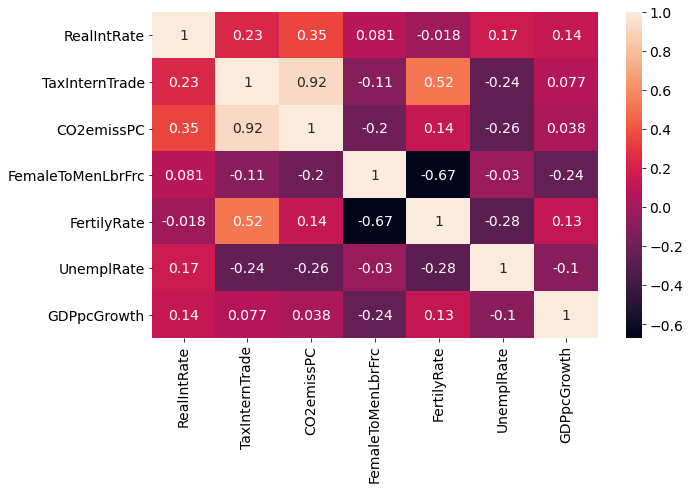

In [17]:
# Plot correlation matrix
sns_heat(corrMatrix)

# Drop Tax on International Trade !!!

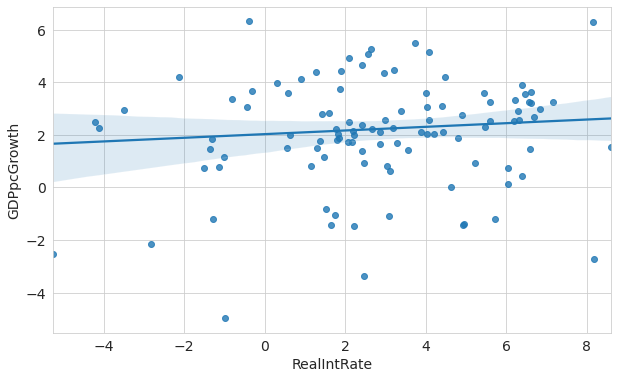

In [18]:
# Not going to be used !!!
sns_plot(df, "RealIntRate", "GDPpcGrowth", regression=True)

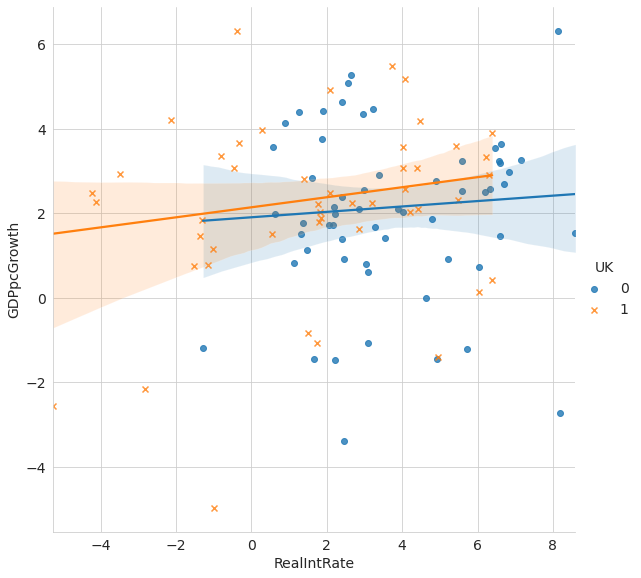

In [19]:
# Plot the GDPpc growth dependance on interest rate for two countries
sns_plot(df, "RealIntRate", "GDPpcGrowth", hue="UK", markers=["o", "x"])

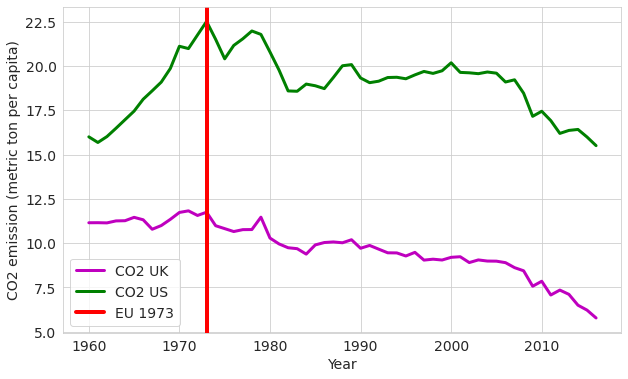

In [20]:
# Plot CO2 emissions
make_plot(UK.year, UK['CO2emissPC'], "CO2 UK", 'm')
make_plot(US.year, US['CO2emissPC'], "CO2 US", 'g')
divide_plot(1973, "EU 1973")
show_plot("Year", "CO2 emission (metric ton per capita)")

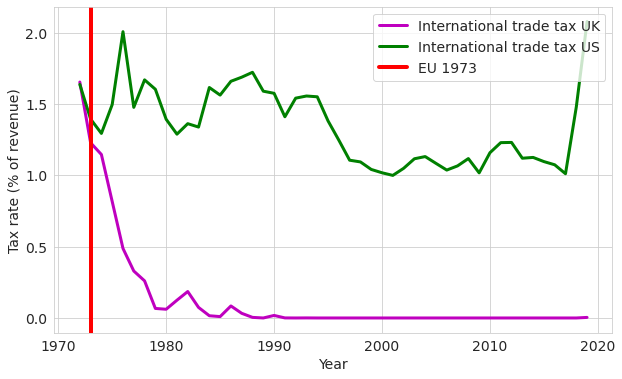

In [21]:
# Plot international trade tax
make_plot(UK.year, UK['TaxInternTrade'], "International trade tax UK", 'm')
make_plot(US.year, US['TaxInternTrade'], "International trade tax US", 'g')
divide_plot(1973, "EU 1973")
show_plot("Year", "Tax rate (% of revenue)")

In [22]:
# Calculate international trade tax means
print("International trade tax US:", UK['TaxInternTrade'].mean())
print("International trade tax UK:", US['TaxInternTrade'].mean())

International trade tax US: 0.12304567737318248
International trade tax UK: 1.3438621998652105


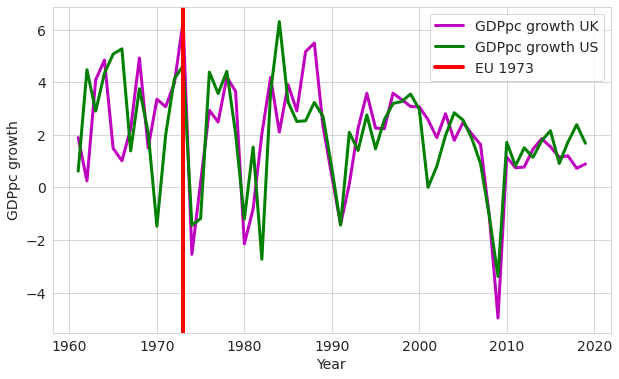

In [23]:
# Most important figure
# GDPpc growth of UK and US with 1973 line
make_plot(UK.year, UK["GDPpcGrowth"], "GDPpc growth UK", 'm')
make_plot(US.year, US["GDPpcGrowth"], "GDPpc growth US", 'g')
divide_plot(1973, "EU 1973")
show_plot("Year", "GDPpc growth")

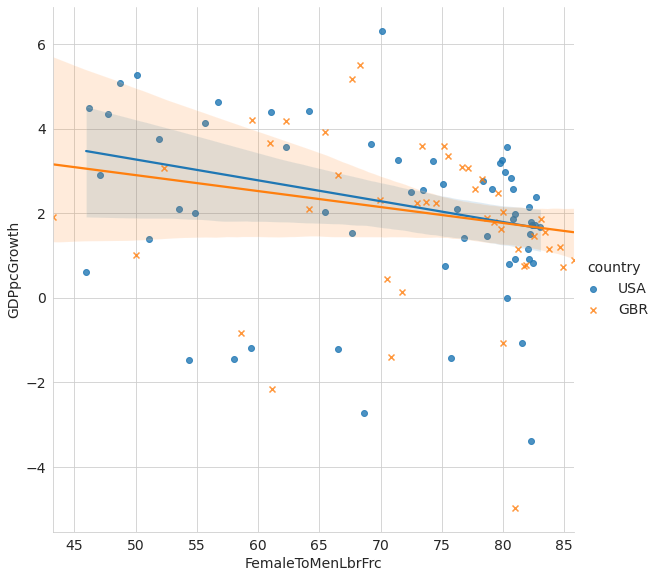

In [24]:
# Female to male ratio in LF, for each contry
# Not going to be added
# Seems spurious and/or hard to argue
# Balance in the ratio is probably the best :)
sns_plot(df, "FemaleToMenLbrFrc", "GDPpcGrowth", hue="country", markers=["o", "x"])